# Análise de dados em conversas de WhatsApp

## Importando Bibliotecas

In [186]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from matplotlib.colors import ListedColormap
import datetime as dt
import nltk
from collections import Counter
from dateutil.relativedelta import relativedelta
from simple_colors import *
import seaborn as sns

## Preparação dos Dados

O WhatsApp permite apenas a exportação de dados em formato txt e com o formato: **[dd/mm/yyyy hh:mm:ss] Autor: Mensagem**

Dessa maneira, precisamos realizar uma série de pré-processamentos para separarmos nossos dados e coletar as informações.

Vamos criar algumas funções para separarmos a data, o horário, o autor e a mensagem de cada registro, além de realizar uma transformação na data.

Como é um formato bem específico, vamos utilizar Regex para moldar nossas funções.

In [187]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [188]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                                  # Primeiro nome
        '([\w]+[\s]+[\w]+):',                        # Primeiro nome + ultimo nome
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',              # Primeiro nome + nome do meio + ultimo nome
        '([\w]+[\s]+[\w]+[\s]+[\w]+[\s]+[\w]+):',    # Primeiro nome + nome do meio + segundo nome do meio + ultimo nome
        '([+]\d{2} \d{2} \d{4}\-\d{4}):',            # Numero de telefone (BR)
        '([\w]+)[\u263a-\U0001f999]+:',              # Nome e emoji             
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [189]:
def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [190]:
parsedData = [] # Lista para manter o controle dos dados para que possam ser usados por um dataframe do Pandas
conversationPath = '_chat(2).txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Pulando a primeira linha do arquivo pois contem informações relacionado à criptografia
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

In [191]:
import datetime
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

## Conhecendo o Dataset

In [192]:
df.head()

,Date,Time,Author,Message
0,2018-12-06,22:43:01,Lucas,🤦🏼‍♂
1,2018-12-06,22:43:40,Cris,hauahuahuahuah
2,2018-12-06,22:45:15,None,‪+55 54 9975‑2069‬: Querem ver a foto da diarr...
3,2018-12-10,16:10:50,None,‎‪+55 54 9975‑2069‬ saiu
4,2018-12-17,16:41:58,Cris,o grupo mais querido do br está de volta


In [193]:
df.shape

(51602, 4)

In [194]:
df['Author'].unique()

array(['Lucas', 'Cris', None, 'Artur Lunardi Di Fante', 'Bristott'],
      dtype=object)

In [195]:
# Excluindo os registros em branco
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51597 entries, 0 to 51601
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     51597 non-null  datetime64[ns]
 1   Time     51597 non-null  object        
 2   Author   51597 non-null  object        
 3   Message  51597 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.0+ MB


In [196]:
df['Author'].unique()

array(['Lucas', 'Cris', 'Artur Lunardi Di Fante', 'Bristott'],
      dtype=object)

## Status do Grupo

**Total de Mensagens**

In [197]:
print(f'O total de mensagens é de: {df.shape[0]}')

O total de mensagens é de: 51597


**Total de Mídias e Figurinhas**

In [198]:
medias = df[df['Message'] == 'imagem ocultada'].shape[0]
figurinhas = df[df['Message'] == 'figurinha omitida'].shape[0]
print(f'O total de mídias é de: {medias}')
print(f'O total de figurinhas é de: {figurinhas}')

O total de mídias é de: 1913
O total de figurinhas é de: 1423


In [199]:
# Função para identificar emojis e guarda-los em uma lista
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df.loc[df.index, "Message"].apply(split_count)

**Total de Emojis**

In [200]:
emojis = sum(df['emoji'].str.len())
print(f'O total de emojis é de: {emojis}')

O total de emojis é de: 1040


In [201]:
# Função para identificar url's
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.loc[:, 'Message'].apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

**Resumo do Grupo**

In [202]:
print(black("Resumo do Grupo", ['bold']))
print('-'*40)
print("Mensagens:", df.shape[0])
print("Medias:", medias)
print("Figurinhas:", figurinhas)
print("Emojis:", emojis)
print("Links:", links)

Resumo do Grupo
----------------------------------------
Mensagens: 51597
Medias: 1913
Figurinhas: 1423
Emojis: 1040
Links: 338


## Separando texto de mídias e figurinhas

In [203]:
# Caso você opte por exportar apenas as mensagens de texto, como foi feito neste caso, as mídias e figurinhas serão identificadas por mensagens de tipo ocultado/omitido
# Dessa maneira, para contabilizarmos esses registros devemos identificar qual mensagem exatamente foi utilizada e separarmos elas
media_messages_df = df[(df['Message'] == 'imagem ocultada')|(df['Message'] == 'video ocultado')]
sticker_messages_df = df[df['Message'] == 'figurinha omitida']

# criamos outro dataframe para contabilizarmos as contagens e retiramos as mensagens que conteham midia e figurinhas
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

messages_df["emojicount"]= df['emoji'].str.len()

In [204]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount,emojicount
0,2018-12-06,22:43:01,Lucas,🤦🏼‍♂,[🤦🏼‍♂],0,4,1,1,1
1,2018-12-06,22:43:40,Cris,hauahuahuahuah,[],0,14,1,1,0
4,2018-12-17,16:41:58,Cris,o grupo mais querido do br está de volta,[],0,40,9,1,0
5,2018-12-17,16:42:00,Cris,ahauhahahaua,[],0,12,1,1,0
6,2018-12-17,16:42:17,Artur Lunardi Di Fante,auhauhauhauhauuaha,[],0,18,1,1,0


In [205]:
messages_df.shape

(48261, 10)

## Status dos Autores

In [206]:
# Cria uma lista com os autores únicos
l = messages_df['Author'].unique()

for i in range(len(l)):
    # Filtrando mensagens por autor
    req_df= messages_df[messages_df["Author"] == l[i]]
    # req_df contem mensagens apenas de um único autor
    print(f'Status do {l[i]} -')
    # shape irá printar o número de colunas, que indiretamente significa o número de mensagens
    print('Mensagens Enviadas: ', req_df.shape[0])
    # word_count contem o total de palavras em uma mensagem. 
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Palavras por mensagem: ', words_per_message)
    # mensagens com media(fotos/arquivos)
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Mensagens com mídia: ', media)
    # mensagens que contenham figurinhas
    stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
    print('Figurinhas enviadas: ', stickers)
    # total de emojis enviados
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis enviados: ', emojis)
    # total de links enviados
    links = sum(req_df["urlcount"])   
    print('Links enviados: ', links)   
    print()

Status do Lucas -
Mensagens Enviadas:  13686
Palavras por mensagem:  3.517316966242876
Mensagens com mídia:  537
Figurinhas enviadas:  232
Emojis enviados:  507
Links enviados:  77

Status do Cris -
Mensagens Enviadas:  16814
Palavras por mensagem:  5.033662424170334
Mensagens com mídia:  863
Figurinhas enviadas:  464
Emojis enviados:  69
Links enviados:  155

Status do Artur Lunardi Di Fante -
Mensagens Enviadas:  11756
Palavras por mensagem:  5.522966995576727
Mensagens com mídia:  308
Figurinhas enviadas:  362
Emojis enviados:  61
Links enviados:  97

Status do Bristott -
Mensagens Enviadas:  6005
Palavras por mensagem:  3.2935886761032473
Mensagens com mídia:  205
Figurinhas enviadas:  365
Emojis enviados:  403
Links enviados:  9



In [207]:
# retiramos as mensagens que contenham url/links
messages_df=messages_df[messages_df["urlcount"]==0]

In [208]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 51601
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          47936 non-null  datetime64[ns]
 1   Time          47936 non-null  object        
 2   Author        47936 non-null  object        
 3   Message       47936 non-null  object        
 4   emoji         47936 non-null  object        
 5   urlcount      47936 non-null  int64         
 6   Letter_Count  47936 non-null  int64         
 7   Word_Count    47936 non-null  int64         
 8   MessageCount  47936 non-null  int64         
 9   emojicount    47936 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 4.0+ MB


# Emojis mais utilizados

## Total de emojis únicos

In [209]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(f'O total de emojis únicos enviados é de: {total_emojis}')

O total de emojis únicos enviados é de: 138


## Mais utilizados

In [210]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 587), ('👀', 21), ('🤔', 18), ('🤦🏻\u200d♂', 14), ('👏🏻', 13), ('😔', 13), ('™️', 12), ('😕', 10), ('🙁', 9), ('🤣', 9), ('😬', 8), ('😢', 8), ('🤦🏽\u200d♂', 7), ('🥰', 7), ('🤤', 7), ('🤢', 6), ('🤷🏼\u200d♂', 6), ('😐', 6), ('😎', 6), ('🌬', 6), ('❗', 6), ('🙃', 5), ('😟', 5), ('🇦🇹', 5), ('😫', 5), ('😥', 4), ('😮', 4), ('❤', 4), ('😱', 4), ('😞', 4), ('🥺', 4), ('🙏🏼', 4), ('😳', 4), ('😰', 4), ('😡', 4), ('⚠️', 4), ('🚨', 4), ('🤦🏼\u200d♂', 3), ('🤮', 3), ('🤨', 3), ('😍', 3), ('🤷🏽\u200d♂', 3), ('👍🏻', 3), ('💸', 3), ('🤷🏻\u200d♂️', 3), ('🗣', 3), ('👃🏿', 3), ('💁🏻\u200d♂️', 3), ('🚀', 3), ('🤦🏻\u200d♂️', 3), ('😅', 2), ('☠', 2), ('😓', 2), ('☹️', 2), ('😯', 2), ('😆', 2), ('👇', 2), ('💙', 2), ('🤓', 2), ('😄', 2), ('💁🏻\u200d♂', 2), ('🙌🏻', 2), ('⭐', 2), ('🍈', 2), ('💔', 2), ('🚰', 2), ('🥤', 2), ('🛢', 2), ('🍀', 2), ('👋🏿', 2), ('🤚🏿', 2), ('🤜🏿', 2), ('😤', 2), ('😖', 2), ('🤷🏿\u200d♀️', 2), ('✅', 2), ('🤦', 1), ('🥵', 1), ('🚬', 1), ('🤠', 1), ('💥', 1), ('😊', 1), ('🐏', 1), ('😙', 1), ('🤷🏻\u200d♂', 1), ('🌝', 1), ('👨🏻', 1), ('❓', 1), ('😃',

In [211]:
# visualização em dataframe
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,587
1,👀,21
2,🤔,18
3,🤦🏻‍♂,14
4,👏🏻,13
...,...,...
133,🤡,1
134,😁,1
135,🐛,1
136,😉,1


## Distribuição do Grupo

**Dias em que houveram mais fluxo de mensagens**

Text(0, 0.5, 'Date')

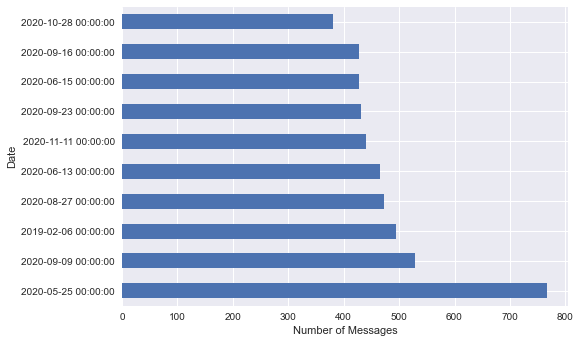

In [212]:
# Datas em que mais houveram mensagens na história do grupo
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

O dia 25 do mês de maio de 2020 foi o dia em que mais houveram mensagens na história do grupo

**Informações sobre a maior mensagem enviada**

In [213]:
# Qual a maior mensagem e informações sobre ela
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-05-09 00:00:00
Time                                                     23:34:13
Author                                     Artur Lunardi Di Fante
Message         GT da Cinderela  >eu tinha uma vizinha >o nome...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                12823
Word_Count                                                   2326
MessageCount                                                    1
emojicount                                                      0
Name: 24208, dtype: object

**Número total de palavras em todo o texto**

In [214]:
text = " ".join(review for review in messages_df.Message)
print ("Existem {} palavras em todas as mensagens.".format(len(text)))

Existem 1129621 palavras em todas as mensagens.


**WordCloud com palavras mais utilizadas**

(-0.5, 399.5, 199.5, -0.5)

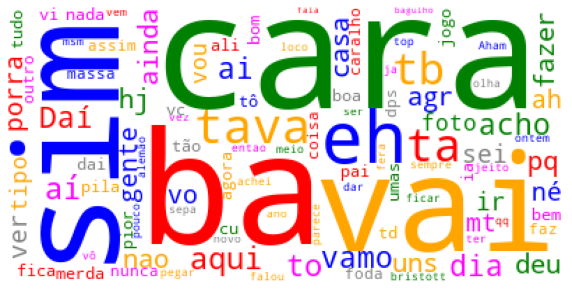

In [215]:
# WordCloud do grupo
stops = stopwords.words('portuguese')
# atualizando a lista de stopwords
newStopWords = ['pra', 'tá', 'pro', 'lá', 'udio ocultado', 'udio', 'ocultado']
stops.extend(newStopWords)
# Definição das cores que serão utilizadas na nuvem de palavras
mapa_cores = ListedColormap(['orange', 'green', 'red', 'magenta', 'blue', 'grey'])
# Criação da nuvem de palavras, com no máximo 100 palavras e utilizando as stop words
nuvem = WordCloud(background_color = 'white',
                  colormap = mapa_cores,
                  stopwords = stops,
                  max_words = 100).generate(text)
# Visualização da nuvem de palavras
plt.figure(figsize = (10, 30))
plt.imshow(nuvem)
plt.axis("off")

# Gráficos e Visualizações

In [216]:
data.head()

,Usuário,Mensagem,Quantidade de Caracteres,Minuto,Hora,Dia,Dia da Semana,Mês,Ano,Data,Data-M
2018-12-06 22:43:01,Lucas,🤦🏼‍♂,4,43,22,6,3,12,2018,2018-12-06,2018-12
2018-12-06 22:43:40,Cris,hauahuahuahuah,14,43,22,6,3,12,2018,2018-12-06,2018-12
2018-12-17 16:41:58,Cris,o grupo mais querido do br está de volta,40,41,16,17,0,12,2018,2018-12-17,2018-12
2018-12-17 16:42:00,Cris,ahauhahahaua,12,42,16,17,0,12,2018,2018-12-17,2018-12
2018-12-17 16:42:17,Artur Lunardi Di Fante,auhauhauhauhauuaha,18,42,16,17,0,12,2018,2018-12-17,2018-12


**Vamos transformar a data no nosso dataframe inicial e passar o índice de datas para o dataframe datas**

In [217]:
df['Date'] = df.loc[:, 'Date'].astype(str)
time_serie = pd.to_datetime(df["Date"] + " " + df["Time"])
data = df.set_index(time_serie)

In [218]:
# Criando TimeSeries
data["Minuto"] = time_serie.dt.minute.values
data["Hora"] = time_serie.dt.hour.values
data["Dia"] = time_serie.dt.day.values
data["Dia da Semana"] = time_serie.apply(lambda x: x.weekday()).values
data["Mês"] = time_serie.dt.month.values
data["Ano"] = time_serie.dt.year.values

# # Ajustando a Coluna UserName e criando a Coluna "Quantidade de Caracteres" com a quantidade de caracteres de cada mensagem
data["Quantidade de Caracteres"] = data["Message"].apply(len)
data.drop('emoji', axis=1, inplace=True)
data.drop('urlcount', axis=1, inplace=True)

In [219]:
data.head()

,Date,Time,Author,Message,Minuto,Hora,Dia,Dia da Semana,Mês,Ano,Quantidade de Caracteres
2018-12-06 22:43:01,2018-12-06,22:43:01,Lucas,🤦🏼‍♂,43,22,6,3,12,2018,4
2018-12-06 22:43:40,2018-12-06,22:43:40,Cris,hauahuahuahuah,43,22,6,3,12,2018,14
2018-12-17 16:41:58,2018-12-17,16:41:58,Cris,o grupo mais querido do br está de volta,41,16,17,0,12,2018,40
2018-12-17 16:42:00,2018-12-17,16:42:00,Cris,ahauhahahaua,42,16,17,0,12,2018,12
2018-12-17 16:42:17,2018-12-17,16:42:17,Artur Lunardi Di Fante,auhauhauhauhauuaha,42,16,17,0,12,2018,18


In [220]:
# Renomenado e Selecionando apenas as colunas necessárias
rename_columns = {"Author": "Usuário", "Message": "Mensagem", "Date": "Data"}
data = data[["Author", "Message", "Quantidade de Caracteres", "Minuto", "Hora", "Dia", "Dia da Semana", "Mês", "Ano", "Date"]].rename(columns=rename_columns)

In [221]:
data.head()

,Usuário,Mensagem,Quantidade de Caracteres,Minuto,Hora,Dia,Dia da Semana,Mês,Ano,Data
2018-12-06 22:43:01,Lucas,🤦🏼‍♂,4,43,22,6,3,12,2018,2018-12-06
2018-12-06 22:43:40,Cris,hauahuahuahuah,14,43,22,6,3,12,2018,2018-12-06
2018-12-17 16:41:58,Cris,o grupo mais querido do br está de volta,40,41,16,17,0,12,2018,2018-12-17
2018-12-17 16:42:00,Cris,ahauhahahaua,12,42,16,17,0,12,2018,2018-12-17
2018-12-17 16:42:17,Artur Lunardi Di Fante,auhauhauhauhauuaha,18,42,16,17,0,12,2018,2018-12-17


**Informações gerais sobre o período analisado**

In [222]:
# Calculando as informações sobre o período analisado
total_time = relativedelta(data.index.max(), data.index.min())
if total_time.years == 1:
    year = str(total_time.years) + " ano"
else:
    year = str(total_time.years) + " anos"
if (total_time.months + 1) == 1:
    month = str(total_time.months + 1) + " mes"
else:
    month = str(total_time.months + 1) + " meses"

dates = {"inicio": "{dia}/{mes}/{ano}".format(**{"dia": data.index.min().day, "mes": data.index.min().month, "ano": data.index.min().year}), 
         "fim": "{dia}/{mes}/{ano}".format(**{"dia": data.index.max().day, "mes": data.index.max().month, "ano": data.index.max().year})}
total_days = (data.index.max() - data.index.min()).days

print(black('Resumo do grupo', ['bold']))
print('-'*40)
print("O período analisado se inicia em {inicio}, termina em {fim}".format(**dates) + " e equivale a cerca de {year} e {month}".format(**{"year": year, "month": month}) + " (total de {} dias).".format(total_days))

print("Percentual de atividade durante o período: {}%".format(str(round(data["Data"].unique().size/total_days * 100, 2))))

data_resume = data[["Mensagem", "Quantidade de Caracteres", "Usuário"]].groupby("Usuário").agg({"Mensagem": "count", "Quantidade de Caracteres": "sum"})

data_resume_total = data_resume.append(data_resume.sum().rename('Total')).rename(columns={"Mensagem": "Quantidade de Mensagens"})
print("Média de mensagens enviadas por dia:", int(round(data_resume_total["Quantidade de Mensagens"].loc["Total"] / total_days)))
data_resume_total.sort_values(by='Quantidade de Mensagens')

Resumo do grupo
----------------------------------------
O período analisado se inicia em 6/12/2018, termina em 18/11/2020 e equivale a cerca de 1 ano e 12 meses (total de 712 dias).
Percentual de atividade durante o período: 88.48%
Média de mensagens enviadas por dia: 72


,Quantidade de Mensagens,Quantidade de Caracteres
Usuário,,
Bristott,6575,116063
Artur Lunardi Di Fante,12426,350517
Lucas,14455,261069
Cris,18141,441290
Total,51597,1168939


In [223]:
# Definindo o Estilo dos Gráficos
plt.style.use("seaborn")

**Percentual de Mensagens Enviadas por Usuário**

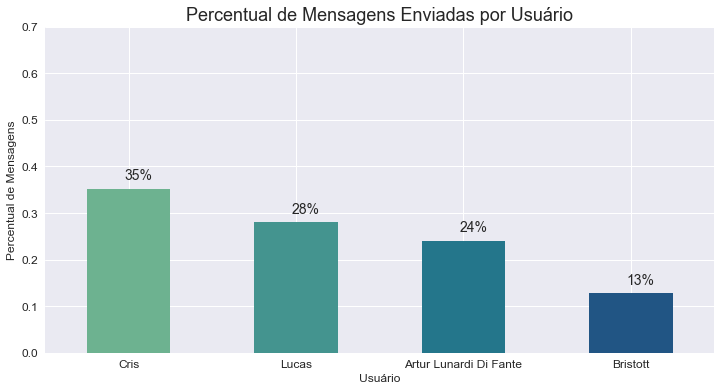

In [224]:
# Plotando o gráfico com o percentual de mensagens enviadas por usuário
ax = data["Usuário"].value_counts(1)
cmap = sns.color_palette("crest", n_colors=len(data['Usuário'].unique()))
vals = ax.plot.bar(figsize=(12, 6), color=cmap).get_yticks()
ax.plot.bar(rot=0, figsize=(12, 6), color=cmap)

plt.title("Percentual de Mensagens Enviadas por Usuário", fontsize=18)
plt.ylabel("Percentual de Mensagens", fontsize=12)
plt.xlabel("Usuário", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
[plt.text(index - 0.025, value + 0.02, str(int(round((value * 100)))) + "%", fontsize=14) for index, value in enumerate(ax.values)]
plt.ylim(0, 0.7)
plt.show()

**Volume de Total Mensagens Enviadas por Dia**

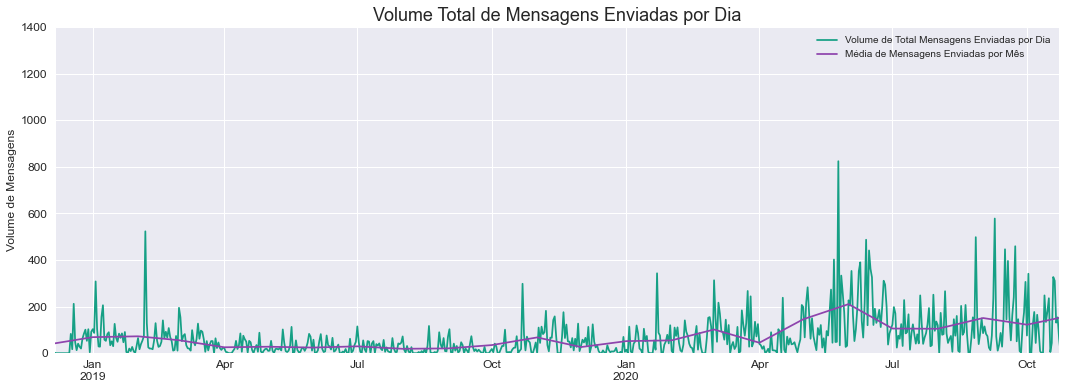

In [225]:
# Plotando o gráfico com o volume total de mensagens enviadas por dia ao longo de todo o período
fig, ax = plt.subplots(1, 1)
data["Mensagem"].resample("D").count().plot.line(ax=ax, figsize=(18, 6), color="#16a085")
data["Mensagem"].resample("D").count().resample("M").mean().plot.line(figsize=(18, 6), color="#8e44ad")

plt.legend(["Volume de Total Mensagens Enviadas por Dia", "Média de Mensagens Enviadas por Mês"])
plt.title("Volume Total de Mensagens Enviadas por Dia", fontsize=18)
plt.ylabel("Volume de Mensagens", fontsize=12)
plt.xlim("2018-12-06", "2020-10-23")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 1400)
plt.show()

- Percebe-se que houve um pico de mensagens entre os meses de abril à julho de 2020, podendo ter relação com a pandemia mundial.
- O grupo tornou-se mais ativo a partir do ano de 2020.

**Média de Mensagens Enviadas por Mês**

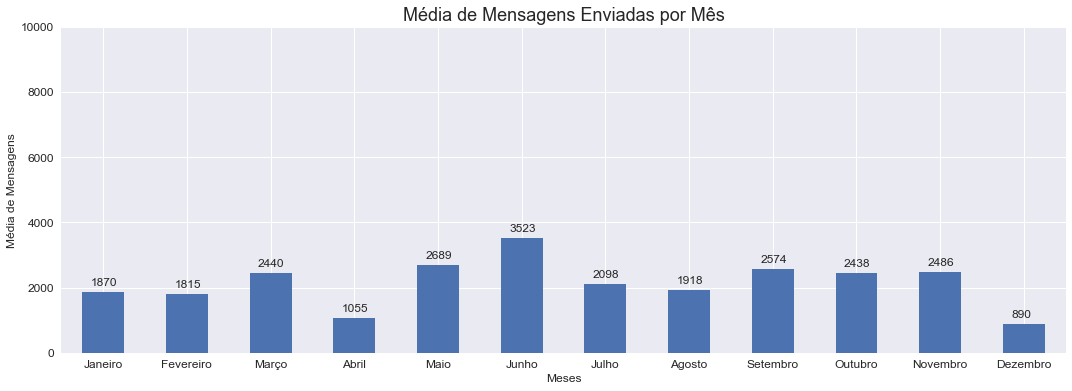

In [226]:
# Plotando o gráfico com a média de mensagens enviadas por mês
data["Data-M"] = data["Data"].str.slice(0, 7)
replace_months = {1: "Janeiro", 2: "Fevereiro", 3: "Março", 4: "Abril", 5: "Maio", 6: "Junho", 7: "Julho", 8: "Agosto", 9: "Setembro", 10: "Outubro", 11: "Novembro", 12: "Dezembro"}
ax = data[["Data-M", "Mês", "Mensagem"]].groupby(["Mês", "Data-M"]).count().groupby("Mês").mean().reset_index().replace(replace_months).set_index("Mês")
ax.plot.bar(rot=0, figsize=(18, 6), legend=False)

plt.title("Média de Mensagens Enviadas por Mês", fontsize=18)
plt.ylabel("Média de Mensagens", fontsize=12)
plt.xlabel("Meses", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
[plt.text(index - 0.15, int(value) + 200, str(int(value)), fontsize=12) for index, value in enumerate(ax["Mensagem"])]
plt.ylim(0, 10000)
plt.show()

**Média de Mensagens Enviadas por Dia da Semana**

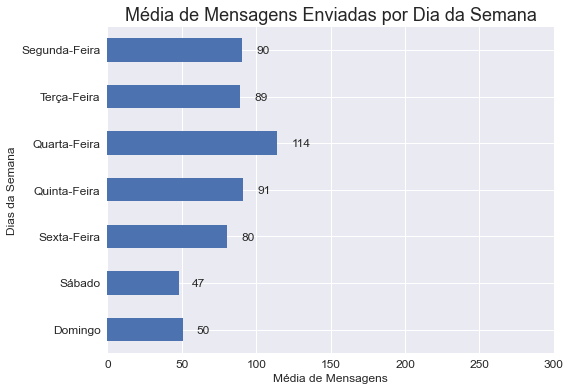

In [227]:
# Plotando o gráfico com a média de mensagens enviadas por dia da semana
replace_weekdays = {0: "Segunda-Feira", 1: "Terça-Feira", 2: "Quarta-Feira", 3: "Quinta-Feira", 4: "Sexta-Feira", 5: "Sábado", 6: "Domingo"}
ax = data[["Data", "Dia da Semana", "Mensagem"]].groupby(["Dia da Semana", "Data"]).count().groupby("Dia da Semana").mean().sort_values("Dia da Semana", ascending=False).reset_index().replace(replace_weekdays).set_index("Dia da Semana")
ax.plot.barh(figsize=(8, 6), legend=False)

plt.xlim(0, 300)
plt.title("Média de Mensagens Enviadas por Dia da Semana", fontsize=18)
plt.xlabel("Média de Mensagens", fontsize=12)
plt.ylabel("Dias da Semana", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
[plt.text(int(value) + 10, index - 0.08, str(int(value)), fontsize=12) for index, value in enumerate(ax["Mensagem"])]
plt.show()

- Quarta feira é o dia mais movimentado da semana

**Percentual Médio de Mensagens Enviadas por Minuto em um Dia**

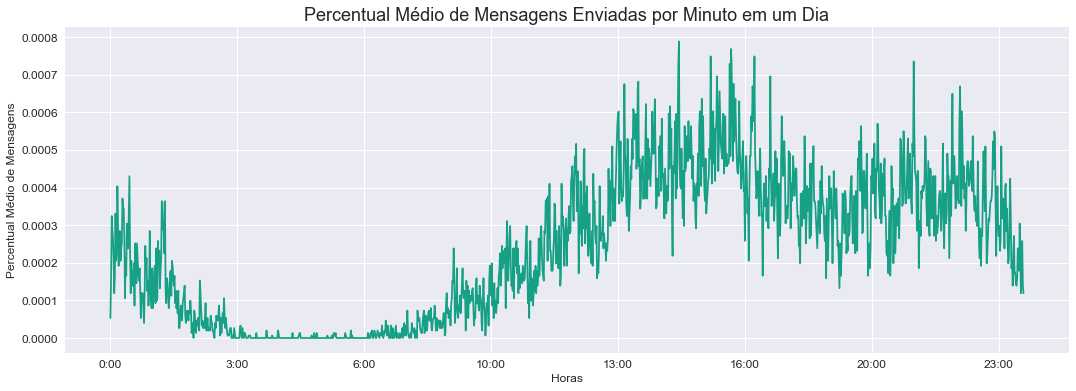

In [228]:
# Plotando o gráfico com o percentual médio de mensagens enviadas por minuto em um dia
count_min = data[["Minuto", "Hora", "Mensagem"]].resample("1min").agg({"Mensagem": "count"})
ax1 = ((pd.concat([count_min, pd.DataFrame({"Minuto": count_min.index.minute, "Hora": count_min.index.hour}, index=count_min.index)], axis=1).groupby(["Hora", "Minuto"]).mean()/212)).plot.line(figsize=(18, 6), color="#16a085", legend=False)
x_vals = ax1.get_xticks()
y_vals = ax1.get_yticks()

ax1.set_xticklabels([str(int(round(x/60, 2))) + ":00" for x in x_vals])
plt.title("Percentual Médio de Mensagens Enviadas por Minuto em um Dia", fontsize=18)
plt.ylabel("Percentual Médio de Mensagens", fontsize=12)
plt.xlabel("Horas", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

- O grupo possui baixa atividade entre 03:00 e 06:00
- A partir das 10:00 o fluxo de mensagens têm um crescimento acelerado, atingindo seu pico entre 13:00 e 16:00
- O período da noite (a partir das 20:00) possui um fluxo de mensagens estável